In [6]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import scipy.stats

## A generative model

In [2]:
# Initialize the parameters
alpha = 0.9
beta = 0.2
gamma = 0.1
lambda_lst = [1,5]

Gamma = np.reshape([
    1-gamma, 0, gamma,
    0, 1-gamma, gamma,
    beta/2, beta/2, 1-beta
], (3,3))

Gamma

array([[0.9, 0. , 0.1],
       [0. , 0.9, 0.1],
       [0.1, 0.1, 0.8]])

In [3]:
# Define P(Z_{t,i}=1|C_t=c)
def p_Z(c):
    if c==0:
        return 1-alpha
    if c==1:
        return alpha
    if c==2:
        return 0.5

# Function to draw n random Z values with C_t=c
def draw_Z(c, n):
    return np.random.binomial(1, p_Z(c), size=n)

# Draw C_{t+1} with P(C_{t+1}=d|C_t=c)
def draw_C(c):
    return np.random.choice(np.shape(Gamma)[0], p=Gamma[:,c])

# Draw n X values with P(X_{t,i}|Z_{t,i}=z)
def draw_X(Z):
    return np.random.poisson(np.take(lambda_lst, Z))

In [4]:
# Forward simulation for a Hidden Markov Network
def forward(n, T):
    simulations = []
    C = 2
    for t in range(T):
        Z = draw_Z(C, n)
        X = draw_X(Z)
        C = draw_C(C)

        simulations.append(X)
    
    return np.array(simulations)

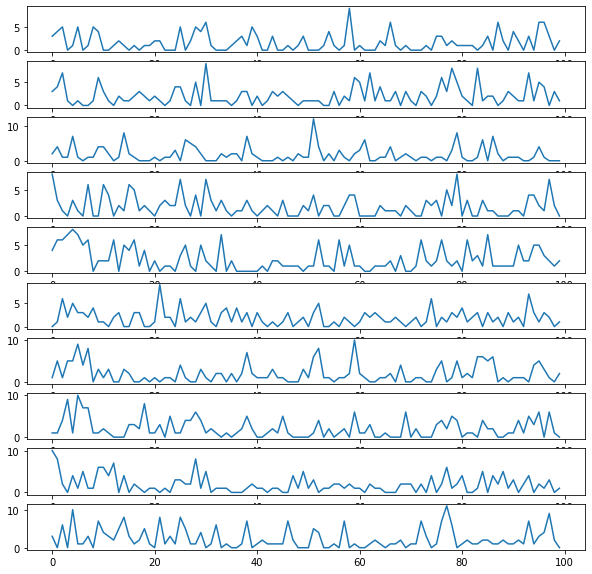

In [5]:
# Choose parameters for forward simulation
n = 10
T = 100

# Simulate data
simulations = forward(n,T)

# Plot the firings of each neuron
fig, axs = plt.subplots(n, figsize=(10,10))

for i in range(n):
    axs[i].plot(range(T), simulations[:, i])


## Inference of Hidden Nodes

In [108]:
# Get P(Z_{t,i}|X_{t,i})
def calc_Z_initials(X):
    return np.column_stack(
        (scipy.stats.poisson.pmf(X, lambda_lst[0]),
        scipy.stats.poisson.pmf(X, lambda_lst[1]))
    )

# Calculate the messages from the X,Z clique to the Z,C clique
def calc_Z_c_messages(Z_initials):
    # P(Z_{t,i}=1|C_t})
    Z_c_initial = np.array([1-alpha, alpha, 0.5])

    # P(Z_{t,i}|C_t})
    Z_c_initial = np.column_stack((np.ones(3) - Z_c_initial, Z_c_initial))
    print('1:')
    print(Z_c_initial)
    print('2:')
    print(Z_initials)

    # sum_{Z} P(Z_{t,i}|X_{t,i})P(C_t|Z_{t,i})
    return np.sum(Z_c_initial @ Z_initials.T, axis=0)


def calc_c_c_message(Z_c_messages, c_c_message):
    message = np.sum(Gamma, axis=0) * np.prod(np.log(Z_c_messages)) * (c_c_message)
    return message / np.sum(message)
    

In [96]:
calc_Z_initials([0,0,1])

array([[0.36787944, 0.00673795],
       [0.36787944, 0.00673795],
       [0.36787944, 0.03368973]])

In [109]:
calc_Z_c_messages(calc_Z_c_messages(calc_Z_initials([0,0,1,0,1])))

1:
[[0.9 0.1]
 [0.1 0.9]
 [0.5 0.5]]
2:
[[0.36787944 0.00673795]
 [0.36787944 0.00673795]
 [0.36787944 0.03368973]
 [0.36787944 0.00673795]
 [0.36787944 0.03368973]]
1:
[[0.9 0.1]
 [0.1 0.9]
 [0.5 0.5]]
2:
[0.56192608 0.56192608 0.60235376 0.56192608 0.60235376]


ValueError: matmul: Input operand 1 has a mismatch in its core dimension 0, with gufunc signature (n?,k),(k,m?)->(n?,m?) (size 5 is different from 2)

In [36]:
np.ones((3,1)) - np.array([
        [1-alpha, alpha, 0.5],
    ]).reshape(3,1)


array([[0.9],
       [0.1],
       [0.5]])

In [90]:
def forward_pass(X):
    T = len(X)
    c_c_message = 1

    for i in range(T):
        Z_initials = calc_Z_initials(X[i])
        Z_c_messages = calc_Z_c_messages(Z_initials)
        c_c_message = calc_c_c_message(Z_c_messages, c_c_message)
        print(c_c_message)
        

In [91]:
forward_pass(simulations)

[1.73109058e-06 1.73109058e-06 1.73109058e-06]
[1.44477848e-11 1.44477848e-11 1.44477848e-11]
[1.62728344e-16 1.62728344e-16 1.62728344e-16]
[5.40834808e-21 5.40834808e-21 5.40834808e-21]
[2.85926961e-27 2.85926961e-27 2.85926961e-27]
[4.26118686e-33 4.26118686e-33 4.26118686e-33]
[2.49132078e-37 2.49132078e-37 2.49132078e-37]
[2.76928964e-42 2.76928964e-42 2.76928964e-42]
[2.78587286e-45 2.78587286e-45 2.78587286e-45]
[4.29980666e-50 4.29980666e-50 4.29980666e-50]
[1.70273336e-54 1.70273336e-54 1.70273336e-54]
[2.36619454e-58 2.36619454e-58 2.36619454e-58]
[4.45845835e-62 4.45845835e-62 4.45845835e-62]
[1.41191284e-65 1.41191284e-65 1.41191284e-65]
[2.16669791e-70 2.16669791e-70 2.16669791e-70]
[2.16018633e-74 2.16018633e-74 2.16018633e-74]
[2.31568234e-78 2.31568234e-78 2.31568234e-78]
[1.32982353e-81 1.32982353e-81 1.32982353e-81]
[1.03969796e-85 1.03969796e-85 1.03969796e-85]
[4.95146516e-88 4.95146516e-88 4.95146516e-88]
[8.06911188e-91 8.06911188e-91 8.06911188e-91]
[1.2637591e-9

/var/folders/s3/51rzg94s5318dvd1cr9t6cq40000gn/T/ipykernel_3253/2479336165.py:20: RuntimeWarning: divide by zero encountered in log
  return np.sum(Gamma, axis=0) * np.exp(np.sum(np.log(Z_c_messages)) + np.log(c_c_message))
